<a href="https://colab.research.google.com/github/Anushkasethi/APS360_Labs/blob/main/Lab2_Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Cats vs Dogs

**Deadline**: Monday, June 06 at 5:00 PM

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Ali Khodadadi -- ali.khodadadi@mail.utoronto.ca

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1NkTV2NJzyhopudm1iAS7JH-oJ0m2C7Rn?usp=sharing

In [ ]:
%%shell
jupyter nbconvert --to html "/content/Lab2_Cats_vs_Dogs.ipynb"

[NbConvertApp] Converting notebook /content/Lab2_Cats_vs_Dogs.ipynb to html
[NbConvertApp] Writing 981703 bytes to /content/Lab2_Cats_vs_Dogs.html


In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
  #So this functions gets the data loaders, based on the target_classes which are chosen, hence the dataloaders consists of data pertaining to only the classes in target class.
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
#https://piazza.com/class/l2t6kj29kt35kr?cid=108  --- How will gradient differ based on white or black image?
#https://stackoverflow.com/questions/65467621/what-are-the-numbers-in-torch-transforms-normalize-and-how-to-select-them

    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling   

#Seed function is used to save the state of a random function, so that it can generate same random numbers on multiple executions of the code on the same machine or on different machines (for a specific seed value).
#https://www.geeksforgeeks.org/random-seed-in-python/

    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    
    #So for val and trainw e are using the same datset i.e trainset and since we r using the sampler, we get seperate indicies for both of them?

    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):

#Why are we normalizing labels???
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

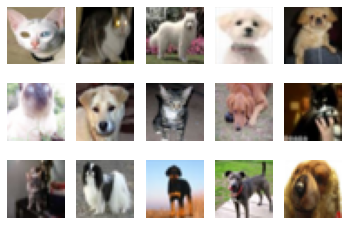

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1) #A total of 15 plots are drawn, i.e until k=14. It has 3 rows and 5 columns and the 3 parameter determines the index of the current plot!
    plt.axis('off') #Removes x and y axis from plot
    plt.imshow(img)

    k += 1
    if k > 14:
        break

Displays 15 different images with intensity lying in [0, 1] range. Image has been transposed to place the colour channel at end.

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
print(len(train_loader.dataset))

50000


In [ ]:
print(len(val_loader.dataset))

50000


In [ ]:
print(len(test_loader.dataset))

10000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

We need a validation model to be able to validate our model during training and decide whether our training is going in the right direction or not. It helps us in tuning the hyperparameteres hence if we were to use the loss/error of the training data set it wouldnt provide us the best possible results for the model and there may be cases of overfitting/memorizing the data. Therefore, we validate our model using a dataset that the model hasnt seen during training and check if the model is giving a good accuracy and less loss.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5) #input channel =3 , output channel = 5, kernel size =5 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
total_params_small = sum(p.numel() for p in small_net.parameters()) #numel is used to find total no. of elements
print(total_params_small)

386


In [ ]:
total_params_large = sum(p.numel() for p in large_net.parameters())
print(total_params_large)

9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

batch_size: 64, learning_rate: 0.01, num_epochs: 30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

The files saved, hold information about the model at different epochs which are as follows:

model_small_bs64_lr0.01_epoch0: saved model at epoch 0 (info about hyperparameters and the other parameters used)

model_small_bs64_lr0.01_epoch1: saved model at epoch 1 (info about hyperparameters and the other parameters used)

model_small_bs64_lr0.01_epoch2: saved model at epoch 2 (info about hyperparameters and the other parameters used)

model_small_bs64_lr0.01_epoch3: saved model at epoch 3 (info about hyperparameters and the other parameters used)

model_small_bs64_lr0.01_epoch4: saved model at epoch 4 (info about hyperparameters and the other parameters used)

Files having information about error and loss are also saved as follows:

model_small_bs64_lr0.01_epoch4_train_err.csv: training error

model_small_bs64_lr0.01_epoch4_train_loss.csv: training loss

model_small_bs64_lr0.01_epoch4_val_err.csv: validation error

model_small_bs64_lr0.01_epoch4_val_loss.csv: validation loss

In [ ]:
train_net(small_net, batch_size=64, learning_rate=0.01, num_epochs=5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.425375, Train loss: 0.6727207241058349 |Validation err: 0.379, Validation loss: 0.655272576957941
Epoch 2: Train err: 0.3655, Train loss: 0.6425767126083374 |Validation err: 0.373, Validation loss: 0.6519250832498074
Epoch 3: Train err: 0.345875, Train loss: 0.6272392911911011 |Validation err: 0.349, Validation loss: 0.619979539886117
Epoch 4: Train err: 0.334125, Train loss: 0.6095622797012329 |Validation err: 0.35, Validation loss: 0.6209760140627623
Epoch 5: Train err: 0.322875, Train loss: 0.6011199426651 |Validation err: 0.329, Validation loss: 0.6130598429590464
Finished Training
Total time elapsed: 23.88 seconds


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
small_net = SmallNet()
train_net(small_net, 64, 0.01, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.446375, Train loss: 0.6813716783523559 |Validation err: 0.3865, Validation loss: 0.6602997500449419
Epoch 2: Train err: 0.37325, Train loss: 0.6497629323005676 |Validation err: 0.3845, Validation loss: 0.6575995869934559
Epoch 3: Train err: 0.359875, Train loss: 0.6388978385925292 |Validation err: 0.3495, Validation loss: 0.6291275043040514
Epoch 4: Train err: 0.346375, Train loss: 0.6246587996482849 |Validation err: 0.356, Validation loss: 0.6221408396959305
Epoch 5: Train err: 0.334375, Train loss: 0.6153830280303955 |Validation err: 0.3275, Validation loss: 0.6188967823982239
Epoch 6: Train err: 0.318, Train loss: 0.6036732516288758 |Validation err: 0.339, Validation loss: 0.6094125052914023
Epoch 7: Train err: 0.315625, Train loss: 0.5944745948314667 |Validation err: 0.329, Validation loss: 0.5974238961935043
Epoch 8: Train err: 0.3085, Train loss: 0.5829453563690186 |Validation err: 0

In [ ]:
large_net = LargeNet()
train_net(large_net, 64, 0.01, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.44475, Train loss: 0.6900203123092651 |Validation err: 0.4285, Validation loss: 0.6807542946189642
Epoch 2: Train err: 0.4195, Train loss: 0.67819615650177 |Validation err: 0.413, Validation loss: 0.6741204150021076
Epoch 3: Train err: 0.39875, Train loss: 0.6658886175155639 |Validation err: 0.3925, Validation loss: 0.6518177818506956
Epoch 4: Train err: 0.373875, Train loss: 0.6490470728874207 |Validation err: 0.406, Validation loss: 0.6635930277407169
Epoch 5: Train err: 0.35375, Train loss: 0.6330237889289856 |Validation err: 0.353, Validation loss: 0.6284337677061558
Epoch 6: Train err: 0.339125, Train loss: 0.6160062110424042 |Validation err: 0.34, Validation loss: 0.6150468923151493
Epoch 7: Train err: 0.32625, Train loss: 0.6001663441658021 |Validation err: 0.335, Validation loss: 0.6086486000567675
Epoch 8: Train err: 0.313875, Train loss: 0.5828366029262543 |Validation err: 0.3325

large_net took longer to train as the number of parameters in large_net is greater than that of small_net 

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

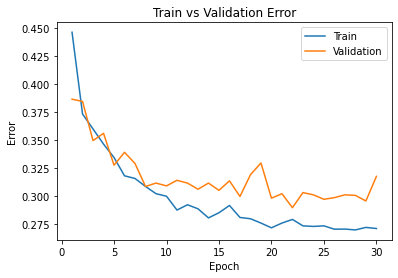

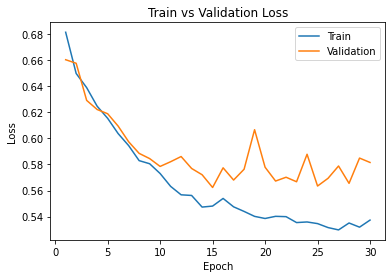

In [ ]:
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

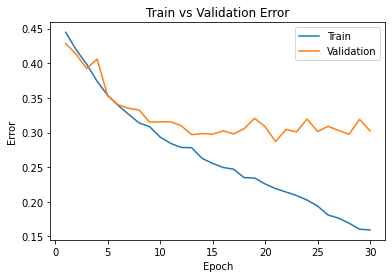

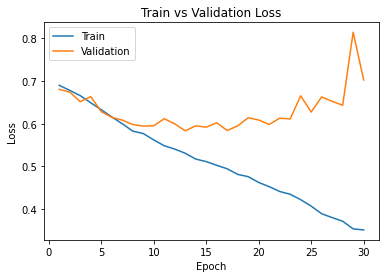

In [ ]:
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

For the small_net model, the training loss and error both display under-fitting, while for the validation loss and error they display signs of underfitting, slightly decreasing as the number of epochs rise.

For the large_net model, the training error shows underfitting as it keeps decreasing as the number of epochs keep rising. However the validation error almost remains at a constant rate. The training loss also displays under-fitting, but the validation loss displays overfitting as it tends to increase by alot as the no. of epochs increase.

Large_net gets a lower validation error however a larger validation loss than small_net.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, 64, 0.001, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

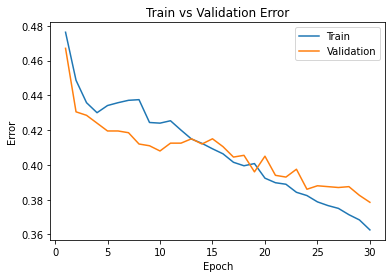

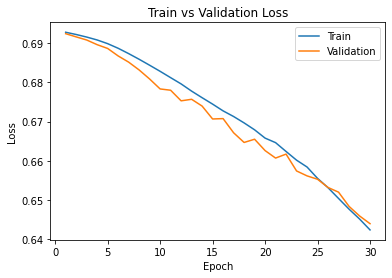

In [ ]:
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_large)

Lowering the learning rate reduces the training time by a bit. The training error and the training loss increased. For the validation, the error obtained is high however the loss shows that overfitting was avoided.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [ ]:
large_net = LargeNet()
train_net(large_net, 64, 0.1, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

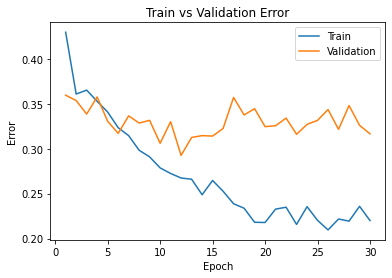

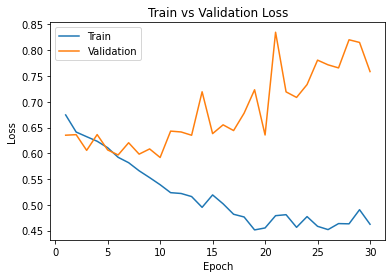

In [ ]:
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path_large)


The model takes around the same time to train. Increasing learning rate caused the training error and loss and validation error and loss to increase. Moreover, we can see that after 15 epochs the validation error and loss are showing overfitting as well.   

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [ ]:
large_net = LargeNet()
train_net(large_net, 512, 0.01, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

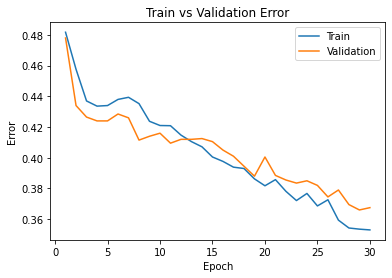

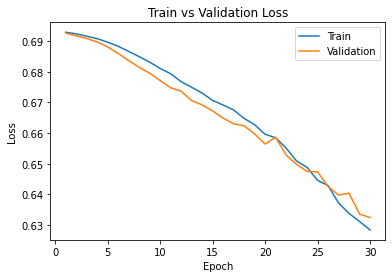

In [ ]:
model_path_large = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

In this case, having a larger batch size tends to train the model quicker than having a smaller batch size. This is because the number of iterations inside a single epoch have decreased, helping the model to train faster. A higher training loss and error is found. Validation error has also increased slightly but the validation loss has decreased slighlty and shows no signs of overfitting.

Iterations is the number of batches needed to complete one epoch

Let’s say we have 2000 training examples that we are going to use .

We can divide the dataset of 2000 examples into batches of 500 then it will take 4 iterations to complete 1 epoch.

Where Batch Size is 500 and Iterations is 4, for 1 complete epoch.


### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [ ]:
large_net = LargeNet()
train_net(large_net, 16, 0.01, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

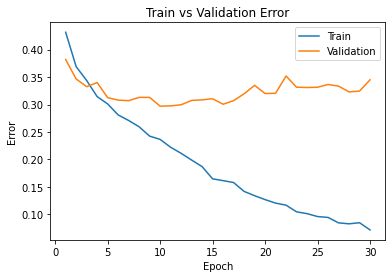

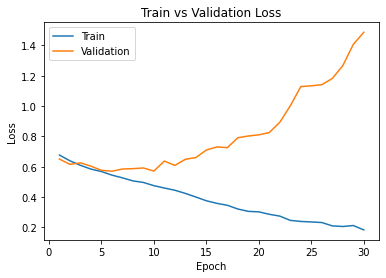

In [ ]:
model_path_large = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

Decreasing the batch size increases the time for training the model as due to the decreased batch size, the number of iterations in one epoch increase, taking more time to train the model. The training loss and error decrease. The error and loss in validation show signs of overfitting, and the loss gets very high.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

Network: large_net (through trails and comparison from small_net I observe large_net works better)

batch_size: 256 (From 3d we see that if batch size is very less then results tend to overfit however if batch size is too large the error and loss increase but dont have overfitting. Hence, I chose 256 to be my batch size somewhere in the middle of 512 and 16)

learning_rate: 0.01 (observing 3a and 3b, it is observed that having a lower and higher learning rate than 0.01 causes different issues hence 0.01 would be the safe option to choose in the middle of them)


### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [ ]:
large_net = LargeNet()
train_net(large_net, 256, 0.01, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.467625, Train loss: 0.6926687750965357 |Validation err: 0.4355, Validation loss: 0.6918838396668434
Epoch 2: Train err: 0.45125, Train loss: 0.6913921367377043 |Validation err: 0.446, Validation loss: 0.6896143183112144
Epoch 3: Train err: 0.428375, Train loss: 0.6892956402152777 |Validation err: 0.418, Validation loss: 0.6862075850367546
Epoch 4: Train err: 0.432375, Train loss: 0.6857246868312359 |Validation err: 0.4185, Validation loss: 0.6810905262827873
Epoch 5: Train err: 0.425875, Train loss: 0.6823424641042948 |Validation err: 0.414, Validation loss: 0.6774001196026802
Epoch 6: Train err: 0.41775, Train loss: 0.6785750649869442 |Validation err: 0.415, Validation loss: 0.6732205599546432
Epoch 7: Train err: 0.4085, Train loss: 0.6743601486086845 |Validation err: 0.412, Validation loss: 0.6696006879210472
Epoch 8: Train err: 0.401625, Train loss: 0.6709103956818581 |Validation err: 0

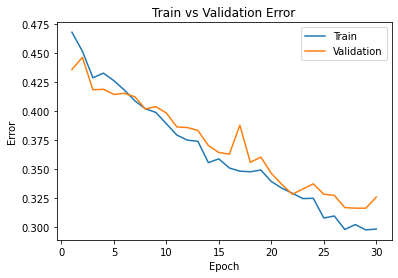

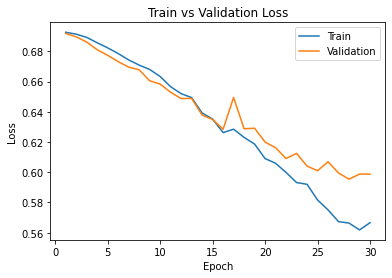

In [ ]:
model_path_large = get_model_name("large", batch_size=256, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

batch_size: After exprementing and using different values for batch sizes, reducing it to 128 gave slightly better results than 256. Moreover its well within the range i.e it is not too big and not too small hence it wont give bad results as in part3.

learning rate: Slightly reduced the learning rate so that it stays closer to the 0.01 mark. Increasing LR (tends to show overfitting) has worse effects than decreasing it, hence decreasing it is a good choice.

epochs: Exprementing with the epochs and comparing the error and loss with the deafult value of the epoch I found that if we set the epoch to 25 the validation error and loss get reduced slightly as shown below. Therefore, I choose 25.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [ ]:
large_net = LargeNet()
train_net(large_net, 128, 0.008, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.45575, Train loss: 0.6922450169684395 |Validation err: 0.426, Validation loss: 0.6905863583087921
Epoch 2: Train err: 0.4465, Train loss: 0.6892826831530011 |Validation err: 0.4125, Validation loss: 0.6848023012280464
Epoch 3: Train err: 0.429125, Train loss: 0.6841231499399457 |Validation err: 0.415, Validation loss: 0.6779178753495216
Epoch 4: Train err: 0.417875, Train loss: 0.6779375975094144 |Validation err: 0.409, Validation loss: 0.6702326275408268
Epoch 5: Train err: 0.407375, Train loss: 0.6721536148162115 |Validation err: 0.402, Validation loss: 0.6651363223791122
Epoch 6: Train err: 0.39275, Train loss: 0.6656142605675591 |Validation err: 0.3915, Validation loss: 0.6601980663836002
Epoch 7: Train err: 0.38225, Train loss: 0.658364697108193 |Validation err: 0.3855, Validation loss: 0.651749849319458
Epoch 8: Train err: 0.374375, Train loss: 0.6494464685046484 |Validation err: 0.3

In [ ]:
large_net = LargeNet()
train_net(large_net, 128, 0.008, 25)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.45575, Train loss: 0.6922450169684395 |Validation err: 0.426, Validation loss: 0.6905863583087921
Epoch 2: Train err: 0.4465, Train loss: 0.6892826831530011 |Validation err: 0.4125, Validation loss: 0.6848023012280464
Epoch 3: Train err: 0.429125, Train loss: 0.6841231499399457 |Validation err: 0.415, Validation loss: 0.6779178753495216
Epoch 4: Train err: 0.417875, Train loss: 0.6779375975094144 |Validation err: 0.409, Validation loss: 0.6702326275408268
Epoch 5: Train err: 0.407375, Train loss: 0.6721536148162115 |Validation err: 0.402, Validation loss: 0.6651363223791122
Epoch 6: Train err: 0.39275, Train loss: 0.6656142605675591 |Validation err: 0.3915, Validation loss: 0.6601980663836002
Epoch 7: Train err: 0.38225, Train loss: 0.658364697108193 |Validation err: 0.3855, Validation loss: 0.651749849319458
Epoch 8: Train err: 0.374375, Train loss: 0.6494464685046484 |Validation err: 0.3

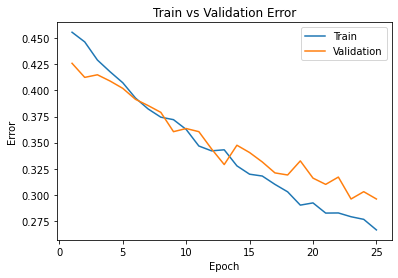

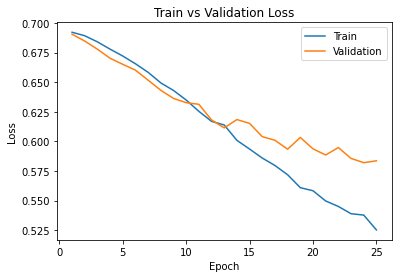

In [ ]:
model_path_large = get_model_name("large", batch_size=128, learning_rate=0.008, epoch=24)
plot_training_curve(model_path_large)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
train_net(net, 128, 0.008, 25)
model_path = get_model_name("large", batch_size=128, learning_rate=0.008, epoch=24)
state = torch.load(model_path)
net.load_state_dict(state)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48625, Train loss: 0.6933931992167518 |Validation err: 0.4285, Validation loss: 0.6896516717970371
Epoch 2: Train err: 0.451625, Train loss: 0.6887558253984603 |Validation err: 0.421, Validation loss: 0.6837496422231197
Epoch 3: Train err: 0.4415, Train loss: 0.6838441973640805 |Validation err: 0.4135, Validation loss: 0.6771321296691895
Epoch 4: Train err: 0.42425, Train loss: 0.6777979618027097 |Validation err: 0.409, Validation loss: 0.6688391827046871
Epoch 5: Train err: 0.40525, Train loss: 0.6703105568885803 |Validation err: 0.403, Validation loss: 0.6615088507533073
Epoch 6: Train err: 0.38325, Train loss: 0.6595576500135755 |Validation err: 0.3825, Validation loss: 0.6490859799087048
Epoch 7: Train err: 0.3775, Train loss: 0.6547642766483246 |Validation err: 0.373, Validation loss: 0.6426345407962799
Epoch 8: Train err: 0.36925, Train loss: 0.646442365078699 |Validation err: 0.375,

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

The choice of these hyperparameters has been explained in the above parts. This has chosen to be the best model as it gives the least validation error and loss calculated so far.


### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=128)

error, loss = evaluate(net, test_loader, nn.BCEWithLogitsLoss())
print("Test classification error:", error)
print("Test classification loss:", loss)

Files already downloaded and verified
Files already downloaded and verified
Test classification error: 0.308
Test classification loss: 0.595095407217741


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

Test classification error is slightly less than the validation error. Test error is expected to be higher as during validation, their are a large number of iterations to help make validation error or the model better and better with each passing epoch, which is not the case when calculating test classification error. 

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

The model should not see the test data beforehand. After it has been trained using the training dataset and the validation dataset, then we should provide it with the test dataset to see how our model is performing on a dataset it has never seen before. It is from the testing dataset that we will be able to judge if our model is good/accurate or not. Hence, it is very important that we use the test data as little as possible as we do not want our model to memorize the test dataset.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.421125, Train loss: 0.6691240185783023 |Validation err: 0.4, Validation loss: 0.65700738504529
Epoch 2: Train err: 0.37475, Train loss: 0.6429551385697865 |Validation err: 0.3875, Validation loss: 0.6506064496934414
Epoch 3: Train err: 0.358, Train loss: 0.6308547504364498 |Validation err: 0.3835, Validation loss: 0.6463229134678841
Epoch 4: Train err: 0.349125, Train loss: 0.6201280790662008 |Validation err: 0.401, Validation loss: 0.6578599251806736
Epoch 5: Train err: 0.339625, Train loss: 0.6137691622688657 |Validation err: 0.3865, Validation loss: 0.645663034170866
Epoch 6: Train err: 0.326875, Train loss: 0.6030668020248413 |Validation err: 0.3785, Validation loss: 0.649161983281374
Epoch 7: Train err: 0.314375, Train loss: 0.5931134753757052 |Validation err: 0.3835, Validation loss: 0.6507213227450848
Epoch 8: Train err: 0.305, Train loss: 0.580164977482387 |Validation err: 0.3655, 

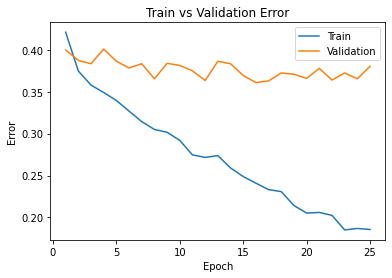

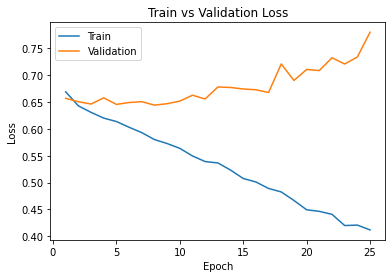

Files already downloaded and verified
Files already downloaded and verified
Test classification error: 0.3815
Test classification loss: 0.7912212125957012


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.layer1 = nn.Linear(3*32*32, 30) ## OPTION 1: HIDDEN UNITS
        self.layer2 = nn.Linear(30, 1)
        self.name = "pigeon"
    def forward(self, img):
        flattened = img.view(-1, 32*32*3)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2.squeeze()

net = Pigeon()
train_net(net, 128, 0.008, 25)
model_path = get_model_name("pigeon", batch_size=128, learning_rate=0.008, epoch=24)
plot_training_curve(model_path)

# load the data
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=128)


# computing the error and loss on a test set
error, loss = evaluate(net, test_loader, nn.BCEWithLogitsLoss())
print("Test classification error:", error)
print("Test classification loss:", loss) 




ANN model has more loss and error (overfitting signs) as compared to the CNN model, hence the CNN model should be utilized over ANN.